In [1]:
import pandas as pd
import networkx as nx

In [2]:
edgelist = pd.read_csv(
    "50M_20201106_PdamXSymbC1_predictions.csv.positive", sep="\t", header=None
)
edgelist.columns = ["source", "target", "weight"]
full_G = nx.from_pandas_edgelist(edgelist, edge_attr=["weight"])

In [3]:
pdam_loc = pd.read_csv("localization_xspecies/pdam_membrane_proteins.csv", sep="\t")
symb_loc = pd.read_csv("localization_xspecies/symb_membrane_proteins.csv", sep="\t")

In [4]:
pdam_prots = set(pdam_loc["Protein_ID"])
symb_prots = set(symb_loc["Protein_ID"])
membrane_prots = pdam_prots.union(symb_prots)
membrane_G = full_G.subgraph(membrane_prots)

In [5]:
len(full_G), len(full_G.edges())

(10669, 66394)

In [6]:
len(membrane_G), len(membrane_G.edges())

(2254, 4669)

In [9]:
from itertools import combinations
from tqdm import tqdm
import numpy as np

pdam_prots_l = sorted(list(pdam_prots.intersection(membrane_G.nodes())))
pdam_pairwise = np.zeros((len(pdam_prots_l), len(pdam_prots_l)))
combin = list(combinations(pdam_prots_l, 2))


def lex_order(a, b):
    if a < b:
        return a, b
    else:
        return b, a


for p1, p2 in tqdm(combin, total=len(combin)):
    p1_neighbors = set(nx.neighbors(membrane_G, p1))
    p2_neighbors = set(nx.neighbors(membrane_G, p2))
    p1_i = pdam_prots_l.index(p1)
    p2_i = pdam_prots_l.index(p2)
    pdam_pairwise[p1_i, p2_i] = len(p1_neighbors.intersection(p2_neighbors))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1203576/1203576 [00:45<00:00, 26177.46it/s]


In [12]:
symb_prots_l = sorted(list(symb_prots.intersection(membrane_G.nodes())))
symb_pairwise = np.zeros((len(symb_prots_l), len(symb_prots_l)))
symb_combin = list(combinations(symb_prots_l, 2))


def lex_order(a, b):
    if a < b:
        return a, b
    else:
        return b, a


for p1, p2 in tqdm(symb_combin, total=len(symb_combin)):
    p1_neighbors = set(nx.neighbors(membrane_G, p1))
    p2_neighbors = set(nx.neighbors(membrane_G, p2))
    p1_i = symb_prots_l.index(p1)
    p2_i = symb_prots_l.index(p2)
    symb_pairwise[p1_i, p2_i] = len(p1_neighbors.intersection(p2_neighbors))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 246051/246051 [00:06<00:00, 36745.00it/s]


In [35]:
pdam_coneighbor_graph = nx.from_pandas_adjacency(
    pd.DataFrame(pdam_pairwise, columns=pdam_prots_l, index=pdam_prots_l)
)
symb_coneighbor_graph = nx.from_pandas_adjacency(
    pd.DataFrame(symb_pairwise, columns=symb_prots_l, index=symb_prots_l)
)

In [39]:
pdam_coneighbor_graph.remove_nodes_from(list(nx.isolates(pdam_coneighbor_graph)))
symb_coneighbor_graph.remove_nodes_from(list(nx.isolates(symb_coneighbor_graph)))

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_degree(G, name="Graph"):
    # From https://networkx.org/documentation/stable/auto_examples/drawing/plot_degree.html
    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    dmax = max(degree_sequence)

    fig = plt.figure("Degree of a random graph", figsize=(8, 8))
    # Create a gridspec for adding subplots of different sizes
    axgrid = fig.add_gridspec(5, 4)

    ax0 = fig.add_subplot(axgrid[0:3, :])
    Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
    pos = nx.spring_layout(Gcc, seed=10396953)
    nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
    nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
    ax0.set_axis_off()

    ax1 = fig.add_subplot(axgrid[3:, :2])
    ax1.plot(degree_sequence, "b-", marker="o")
    ax1.set_title("Degree Rank Plot")
    ax1.set_ylabel("Degree")
    ax1.set_xlabel("Rank")

    ax2 = fig.add_subplot(axgrid[3:, 2:])
    ax2.bar(*np.unique(degree_sequence, return_counts=True))
    ax2.set_title("Degree histogram")
    ax2.set_xlabel("Degree")
    ax2.set_ylabel("# of Nodes")

    fig.tight_layout()
    sns.despine()
    plt.suptitle(f"{name} ({len(G)} nodes / {len(G.edges())} edges)")
    plt.show()

In [56]:
pdam_pairwise.shape

(1552, 1552)

In [75]:
pdam_coneighbor_graph.degree()["pdam_00000692-RA"]

615

In [76]:
for i in nx.ego_graph(membrane_G, "pdam_00000692-RA").nodes():
    print(i, len(nx.ego_graph(membrane_G, i)))

SymbC1.scaffold4455.2 167
pdam_00000692-RA 12
SymbC1.scaffold1744.6 232
SymbC1.scaffold7386.2 166
SymbC1.scaffold5701.4 82
SymbC1.scaffold7030.2 95
SymbC1.scaffold380.3 37
SymbC1.scaffold945.1 15
SymbC1.scaffold3391.8 3
SymbC1.scaffold3889.1 54
SymbC1.scaffold117.6 36
SymbC1.scaffold4253.4 77


In [61]:
g_ego = nx.ego_graph(pdam_coneighbor_graph, "pdam_00000020-RA")

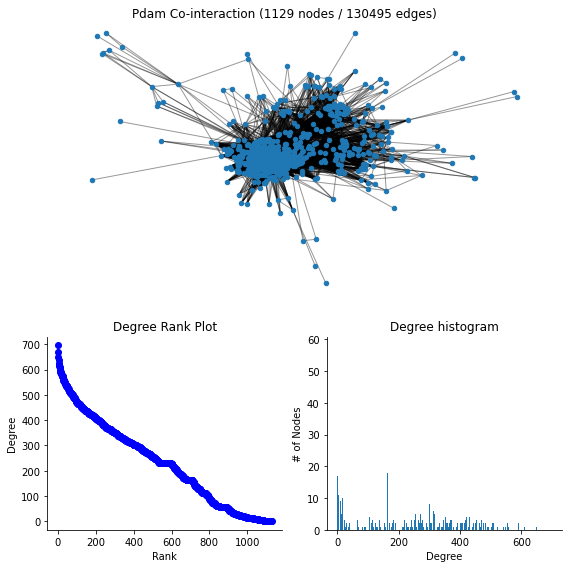

In [55]:
plot_degree(pdam_coneighbor_graph, name="Pdam Co-interaction")

In [57]:
symb_pairwise.shape

(702, 702)

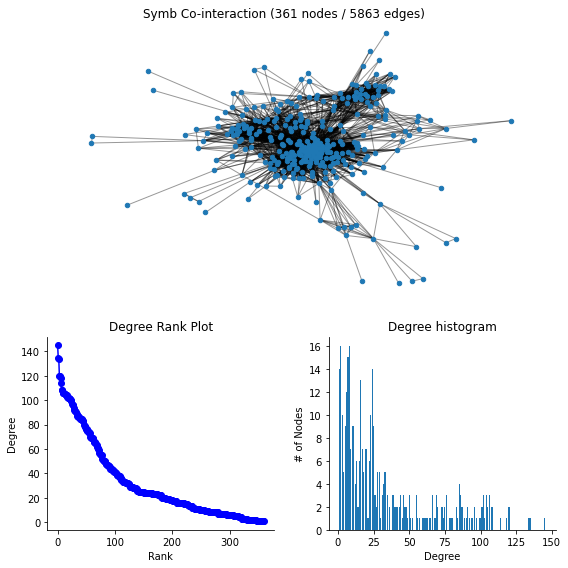

In [54]:
plot_degree(symb_coneighbor_graph, name="Symb Co-interaction")

In [81]:
nx.to_pandas_edgelist(pdam_coneighbor_graph).to_csv(
    "pdam_membrane_xspecies_coneighbor.tsv", sep="\t", header=False, index=False
)
nx.to_pandas_edgelist(symb_coneighbor_graph).to_csv(
    "symb_membrane_xspecies_coneighbor.tsv", sep="\t", header=False, index=False
)

In [46]:
nx.to_pandas_edgelist(membrane_G).to_csv(
    "20240130_membrane_graph.tsv", sep="\t", header=None, index=None
)

---

In [51]:
import json
import pickle as pk

with open(
    "./50M_20201106_PdamXSymbC1_distances_0.5thresh.DSD1.clusterDict.json", "r"
) as f:
    clusters = json.load(f)

In [55]:
p = [k for k, v in clusters.items() if "pdam_00017444-RA" in v["proteins"]]

In [58]:
k = list(clusters.keys())

In [60]:
v = clusters[k[0]]